In [1]:
# Alternativa más robusta
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

import tensorflow as tf
tf.config.experimental.enable_op_determinism()

2025-07-30 15:05:34.261896: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-30 15:05:34.335166: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753909534.355549   13134 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753909534.363179   13134 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753909534.387519   13134 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
import tensorflow as tf
import os

print("=== VERIFICACIÓN DE ENTORNO ===")
print("CUDA_HOME:", os.environ.get('CUDA_HOME', 'No configurada'))
print("LD_LIBRARY_PATH configurado:", 'targets/x86_64-linux/lib' in os.environ.get('LD_LIBRARY_PATH', ''))

print("\n=== PRUEBA DE GPU ===")
print("TensorFlow version:", tf.__version__)
print("CUDA compilado:", tf.test.is_built_with_cuda())
print("GPU detectada:", tf.config.list_physical_devices('GPU'))

# Test crucial - operación en GPU
try:
    with tf.device('/GPU:0'):
        a = tf.constant([[1.0, 2.0]])
        b = tf.constant([[3.0], [4.0]])
        result = tf.matmul(a, b)
        print("✅ GPU funcionando correctamente:", result.numpy())
        print("✅ Dispositivo usado:", result.device)
except Exception as e:
    print("❌ Error en GPU:", str(e))

=== VERIFICACIÓN DE ENTORNO ===
CUDA_HOME: /home/ivana/miniconda3/envs/deeplearning
LD_LIBRARY_PATH configurado: True

=== PRUEBA DE GPU ===
TensorFlow version: 2.19.0
CUDA compilado: True
GPU detectada: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
✅ GPU funcionando correctamente: [[11.]]
✅ Dispositivo usado: /job:localhost/replica:0/task:0/device:GPU:0


2025-07-30 15:05:39.781774: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1753909539.781825   13134 gpu_process_state.cc:208] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1753909539.783628   13134 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:64:00.0, compute capability: 8.9


In [3]:
# Probar que GPU funciona antes del entrenamiento
with tf.device('/GPU:0'):
    test_tensor = tf.constant([[1.0, 2.0], [3.0, 4.0]])
    result = tf.matmul(test_tensor, test_tensor)
    print("GPU funcionando:", result)

GPU funcionando: tf.Tensor(
[[ 7. 10.]
 [15. 22.]], shape=(2, 2), dtype=float32)


In [14]:
#Cargar datos
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.io
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams.update({'font.size': 18})

mat_contents = scipy.io.loadmat(os.path.join("/home/ivana/ml_projects/allFaces.mat"))
faces = mat_contents['faces']
m = int(mat_contents['m'])
n = int(mat_contents['n'])
nfaces = np.ndarray.flatten(mat_contents['nfaces'])


/tmp/ipykernel_13134/1052741379.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  m = int(mat_contents['m'])
/tmp/ipykernel_13134/1052741379.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  n = int(mat_contents['n'])


In [15]:
# Create etiquetas para cada cara
labels = np.zeros(faces.shape[1])
for i in range(len(nfaces)):
  labels[np.sum(nfaces[:(i)]):np.sum(nfaces[:(i+1)])] = i+1

# Agregarlas etiquetas al arreglo faces
faces = np.concatenate((labels.reshape((1, faces.shape[1])), faces), axis=0)



In [16]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
import numpy as np

#Ordenar el areglo en vectores columna
faces_aux = faces.T
X = faces_aux[:,1:]
y = faces_aux[:,0]
# Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Imprimir las formas de los conjuntos de entrenamiento y prueba
print("Forma de X_train:", X_train.shape)
print("Forma de y_train:", y_train.shape)
print("Forma de X_test:", X_test.shape)
print("Forma de y_test:", y_test.shape)


Forma de X_train: (1928, 32256)
Forma de y_train: (1928,)
Forma de X_test: (482, 32256)
Forma de y_test: (482,)


In [17]:
import numpy as np

num_imagenes_digito_train = {int(digito): int(np.sum(y_train == digito)) for digito in np.unique(y_train)}
num_imagenes_digito_test = {int(digito): int(np.sum(y_test == digito)) for digito in np.unique(y_test)}

print("Número de imágenes de cada dígito en X_train:")
print(num_imagenes_digito_train)

print("\nNúmero de imágenes de cada dígito en X_test:")
print(num_imagenes_digito_test)

Número de imágenes de cada dígito en X_train:
{1: 51, 2: 50, 3: 51, 4: 51, 5: 50, 6: 51, 7: 51, 8: 51, 9: 51, 10: 51, 11: 48, 12: 48, 13: 48, 14: 51, 15: 50, 16: 51, 17: 51, 18: 51, 19: 51, 20: 51, 21: 51, 22: 51, 23: 51, 24: 52, 25: 52, 26: 51, 27: 51, 28: 51, 29: 51, 30: 51, 31: 51, 32: 51, 33: 51, 34: 51, 35: 51, 36: 51, 37: 51, 38: 51}

Número de imágenes de cada dígito en X_test:
{1: 13, 2: 12, 3: 13, 4: 13, 5: 12, 6: 13, 7: 13, 8: 13, 9: 13, 10: 13, 11: 12, 12: 11, 13: 12, 14: 12, 15: 12, 16: 12, 17: 12, 18: 13, 19: 13, 20: 13, 21: 13, 22: 13, 23: 13, 24: 12, 25: 12, 26: 13, 27: 13, 28: 13, 29: 13, 30: 13, 31: 13, 32: 13, 33: 13, 34: 13, 35: 13, 36: 13, 37: 13, 38: 13}


In [8]:
import numpy as np

# Calcular la cantidad de imágenes de cada dígito en X_train y X_test
num_imagenes_digito_train = {digito: np.sum(y_train == digito) for digito in np.unique(y_train)}
num_imagenes_digito_test = {digito: np.sum(y_test == digito) for digito in np.unique(y_test)}

# Imprimir la cantidad de imágenes de cada dígito en X_train y X_test
print("Número de imágenes de cada dígito en X_train:")
print(num_imagenes_digito_train)

print("\nNúmero de imágenes de cada dígito en X_test:")
print(num_imagenes_digito_test)


Número de imágenes de cada dígito en X_train:
{np.float64(1.0): np.int64(51), np.float64(2.0): np.int64(50), np.float64(3.0): np.int64(51), np.float64(4.0): np.int64(51), np.float64(5.0): np.int64(50), np.float64(6.0): np.int64(51), np.float64(7.0): np.int64(51), np.float64(8.0): np.int64(51), np.float64(9.0): np.int64(51), np.float64(10.0): np.int64(51), np.float64(11.0): np.int64(48), np.float64(12.0): np.int64(48), np.float64(13.0): np.int64(48), np.float64(14.0): np.int64(51), np.float64(15.0): np.int64(50), np.float64(16.0): np.int64(51), np.float64(17.0): np.int64(51), np.float64(18.0): np.int64(51), np.float64(19.0): np.int64(51), np.float64(20.0): np.int64(51), np.float64(21.0): np.int64(51), np.float64(22.0): np.int64(51), np.float64(23.0): np.int64(51), np.float64(24.0): np.int64(52), np.float64(25.0): np.int64(52), np.float64(26.0): np.int64(51), np.float64(27.0): np.int64(51), np.float64(28.0): np.int64(51), np.float64(29.0): np.int64(51), np.float64(30.0): np.int64(51), np

/home/ivana/miniconda3/envs/deeplearning/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)


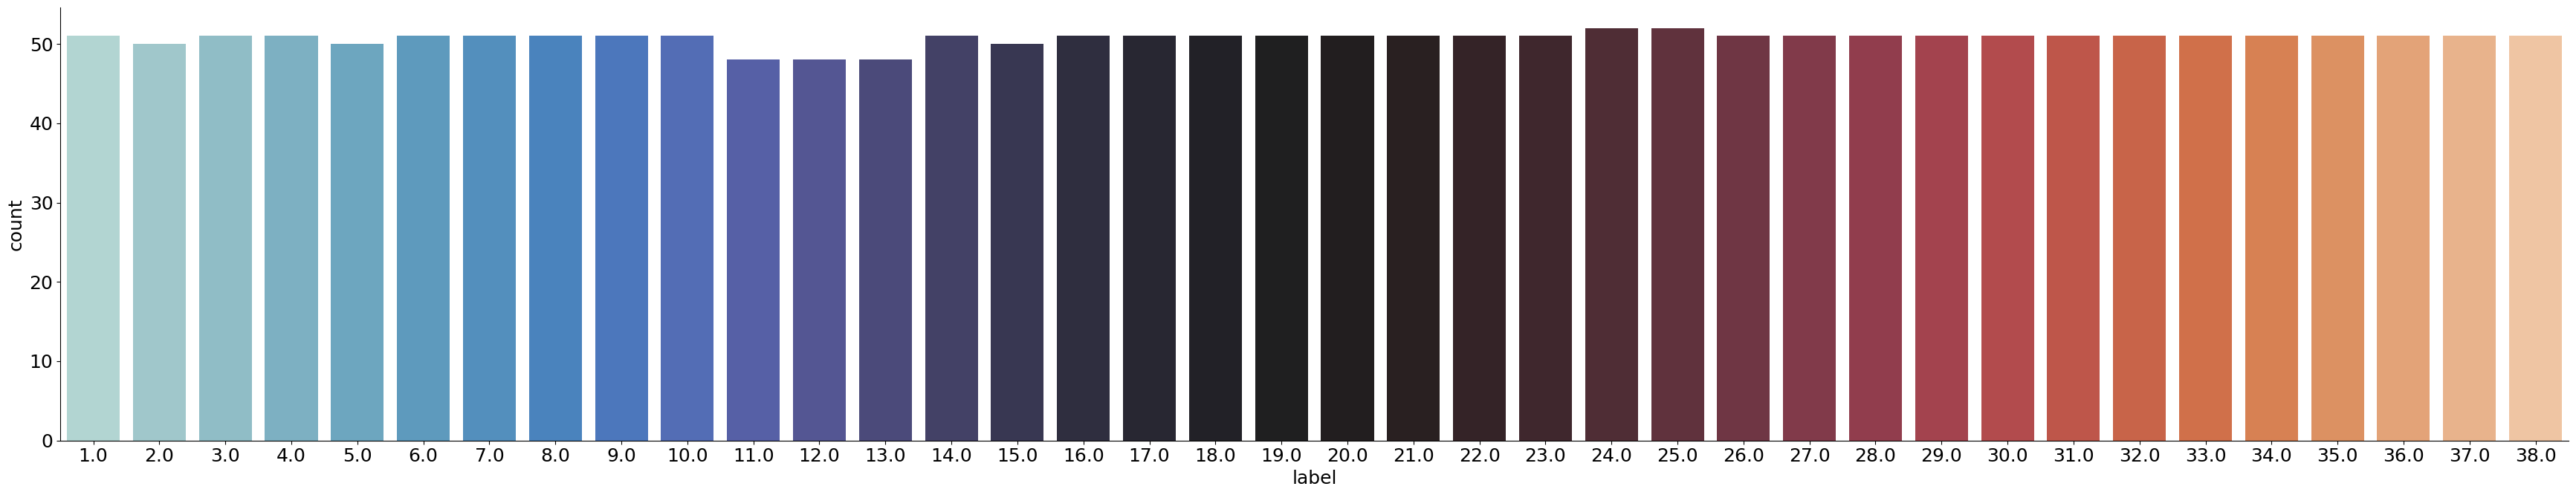

label
1.0     51
2.0     50
3.0     51
4.0     51
5.0     50
6.0     51
7.0     51
8.0     51
9.0     51
10.0    51
11.0    48
12.0    48
13.0    48
14.0    51
15.0    50
16.0    51
17.0    51
18.0    51
19.0    51
20.0    51
21.0    51
22.0    51
23.0    51
24.0    52
25.0    52
26.0    51
27.0    51
28.0    51
29.0    51
30.0    51
31.0    51
32.0    51
33.0    51
34.0    51
35.0    51
36.0    51
37.0    51
38.0    51
Name: count, dtype: int64


In [18]:
# Convertir y_train a un DataFrame de pandas
df_train = pd.DataFrame({'label': y_train})

# Crear una cuadrícula de gráficos con una gráfica para cada dígito
g = sns.FacetGrid(df_train, height=7, aspect=5)
g.map(sns.countplot, 'label', palette="icefire",order=sorted(df_train['label'].unique()))

plt.show()

# Obtener el recuento de valores únicos en y_train
print(df_train['label'].value_counts().sort_index())


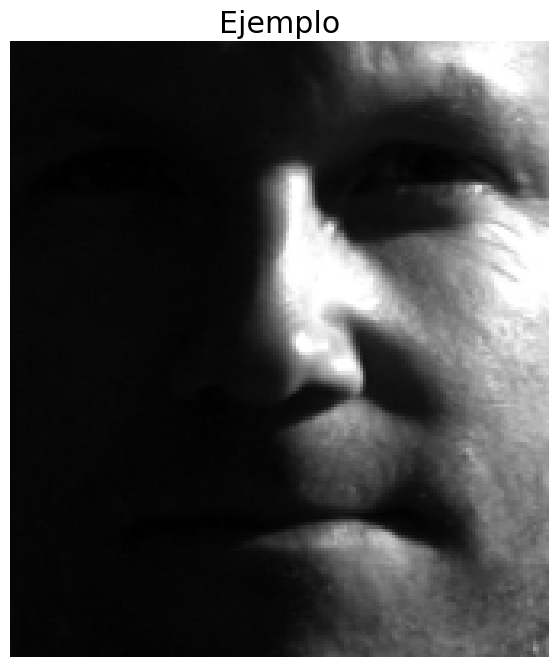

In [19]:
#Imagen ejemplo
img = X_train[11,:]
img = img.reshape((m,n)).T
plt.imshow(img,cmap='gray')
plt.title("Ejemplo")
plt.axis("off")
plt.show()

In [20]:
# normalize inputs from 0-255 to 0.0-1.0
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255


In [21]:
# Reshape
X_train = X_train.reshape(-1,n,m,1)
X_test = X_test.reshape(-1,n,m,1)

#Tamaños
print("X_train shape: ",X_train.shape)
print("y_train shape: ",y_train.shape)
print("X_test shape: ",X_test.shape)
print("y_test shape: ",y_test.shape)


X_train shape:  (1928, 192, 168, 1)
y_train shape:  (1928,)
X_test shape:  (482, 192, 168, 1)
y_test shape:  (482,)


In [22]:
#One hot encoding
from keras.utils import to_categorical

# Restar 1 a las etiquetas para que empiecen desde 0
y_train = y_train - 1
y_test = y_test - 1

# Aplicar one-hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

num_clases = y_test.shape[1]
print(y_test.shape)
print(y_train.shape)


(482, 38)
(1928, 38)


In [23]:
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.callbacks import ReduceLROnPlateau


model = Sequential()
#
model.add(Conv2D(filters = 8, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', input_shape = (n,m,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
#
model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))
# fully connected
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(38, activation = "softmax"))

/home/ivana/miniconda3/envs/deeplearning/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
# Define the optimizer
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

In [25]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [26]:
epochs = 50  # for better result increase the epochs
batch_size = 64

In [27]:
from tensorflow import keras
from keras.utils import image_dataset_from_directory

# Configurar el aumento de datos
data_augmentation = keras.Sequential([
  keras.layers.RandomFlip("horizontal"),
  keras.layers.RandomRotation(0.1),
  keras.layers.RandomZoom(0.1),
])

In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# data augmentation
datagen = ImageDataGenerator(
        featurewise_center = False,  # set input mean to 0 over the dataset
        samplewise_center = False,  # set each sample mean to 0
        featurewise_std_normalization = False,  # divide inputs by std of the dataset
        samplewise_std_normalization = False,  # divide each input by its std
        zca_whitening = False,  # dimesion reduction
        rotation_range = 0,  # randomly rotate images in the range 5 degrees
        zoom_range = 0, # Randomly zoom image 10%
        width_shift_range = 0,  # randomly shift images horizontally 10%
        height_shift_range = 0,  # randomly shift images vertically 10%
        horizontal_flip = False,  # randomly flip images
        vertical_flip = False)  # randomly flip images

datagen.fit(X_train)

In [29]:
# Fit the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size), validation_data=(X_test, y_test), epochs=epochs)


# Final evaluation of the model
scores = model.evaluate(X_test,y_test, verbose=0)
print("Accuracy: %0.2f%%" % (scores[1]*100))

Epoch 1/50


/home/ivana/miniconda3/envs/deeplearning/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
E0000 00:00:1753909690.254708   13134 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1753909690.366809   13324 cuda_dnn.cc:529] Loaded cuDNN version 90300


30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.0304 - loss: 3.8648

2025-07-30 15:08:13.139317: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.0309 - loss: 3.8563 - val_accuracy: 0.1307 - val_loss: 3.5925
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.0727 - loss: 3.5373 - val_accuracy: 0.2199 - val_loss: 3.4128
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.1488 - loss: 3.2757 - val_accuracy: 0.4046 - val_loss: 2.8020
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.2572 - loss: 2.7417 - val_accuracy: 0.6598 - val_loss: 1.8774
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.4410 - loss: 2.0109 - val_accuracy: 0.8195 - val_loss: 1.1177
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.6169 - loss: 1.3562 - val_accuracy: 0.8631 - val_loss: 0.7813
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.7174 - loss: 0.9823 - val_accuracy: 0.9232 - val_loss: 0.5354
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7694 - loss: 0.7877 - val_accuracy: 0.9232 - val_loss: 0.

2025-07-30 15:09:05.767492: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


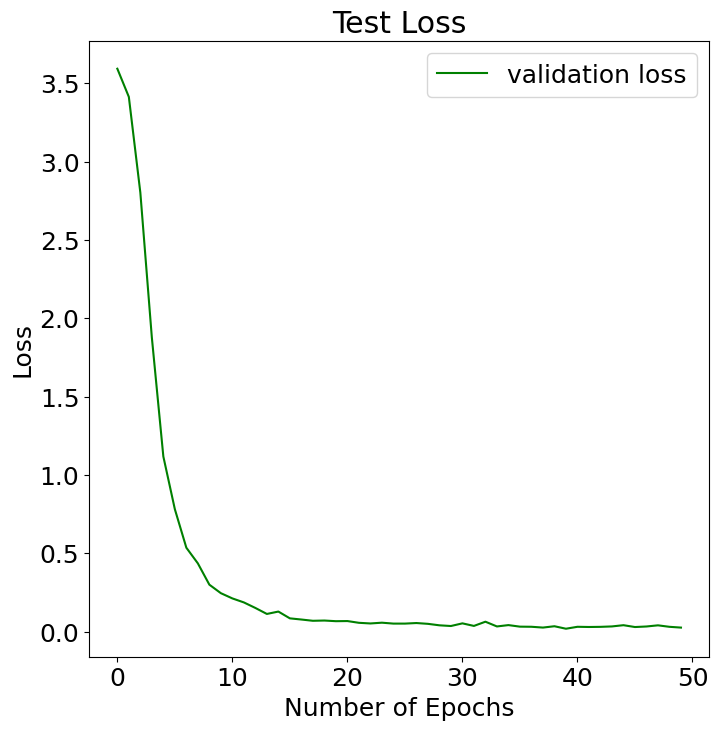

In [30]:
# Plot the loss and accuracy curves for training and validation 
plt.plot(history.history['val_loss'], color='g', label="validation loss")
plt.title("Test Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [31]:
print("\nNúmero de imágenes de cada dígito en X_test:")
print(num_imagenes_digito_test)


Número de imágenes de cada dígito en X_test:
{1: 13, 2: 12, 3: 13, 4: 13, 5: 12, 6: 13, 7: 13, 8: 13, 9: 13, 10: 13, 11: 12, 12: 11, 13: 12, 14: 12, 15: 12, 16: 12, 17: 12, 18: 13, 19: 13, 20: 13, 21: 13, 22: 13, 23: 13, 24: 12, 25: 12, 26: 13, 27: 13, 28: 13, 29: 13, 30: 13, 31: 13, 32: 13, 33: 13, 34: 13, 35: 13, 36: 13, 37: 13, 38: 13}


 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

2025-07-30 15:09:29.575067: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


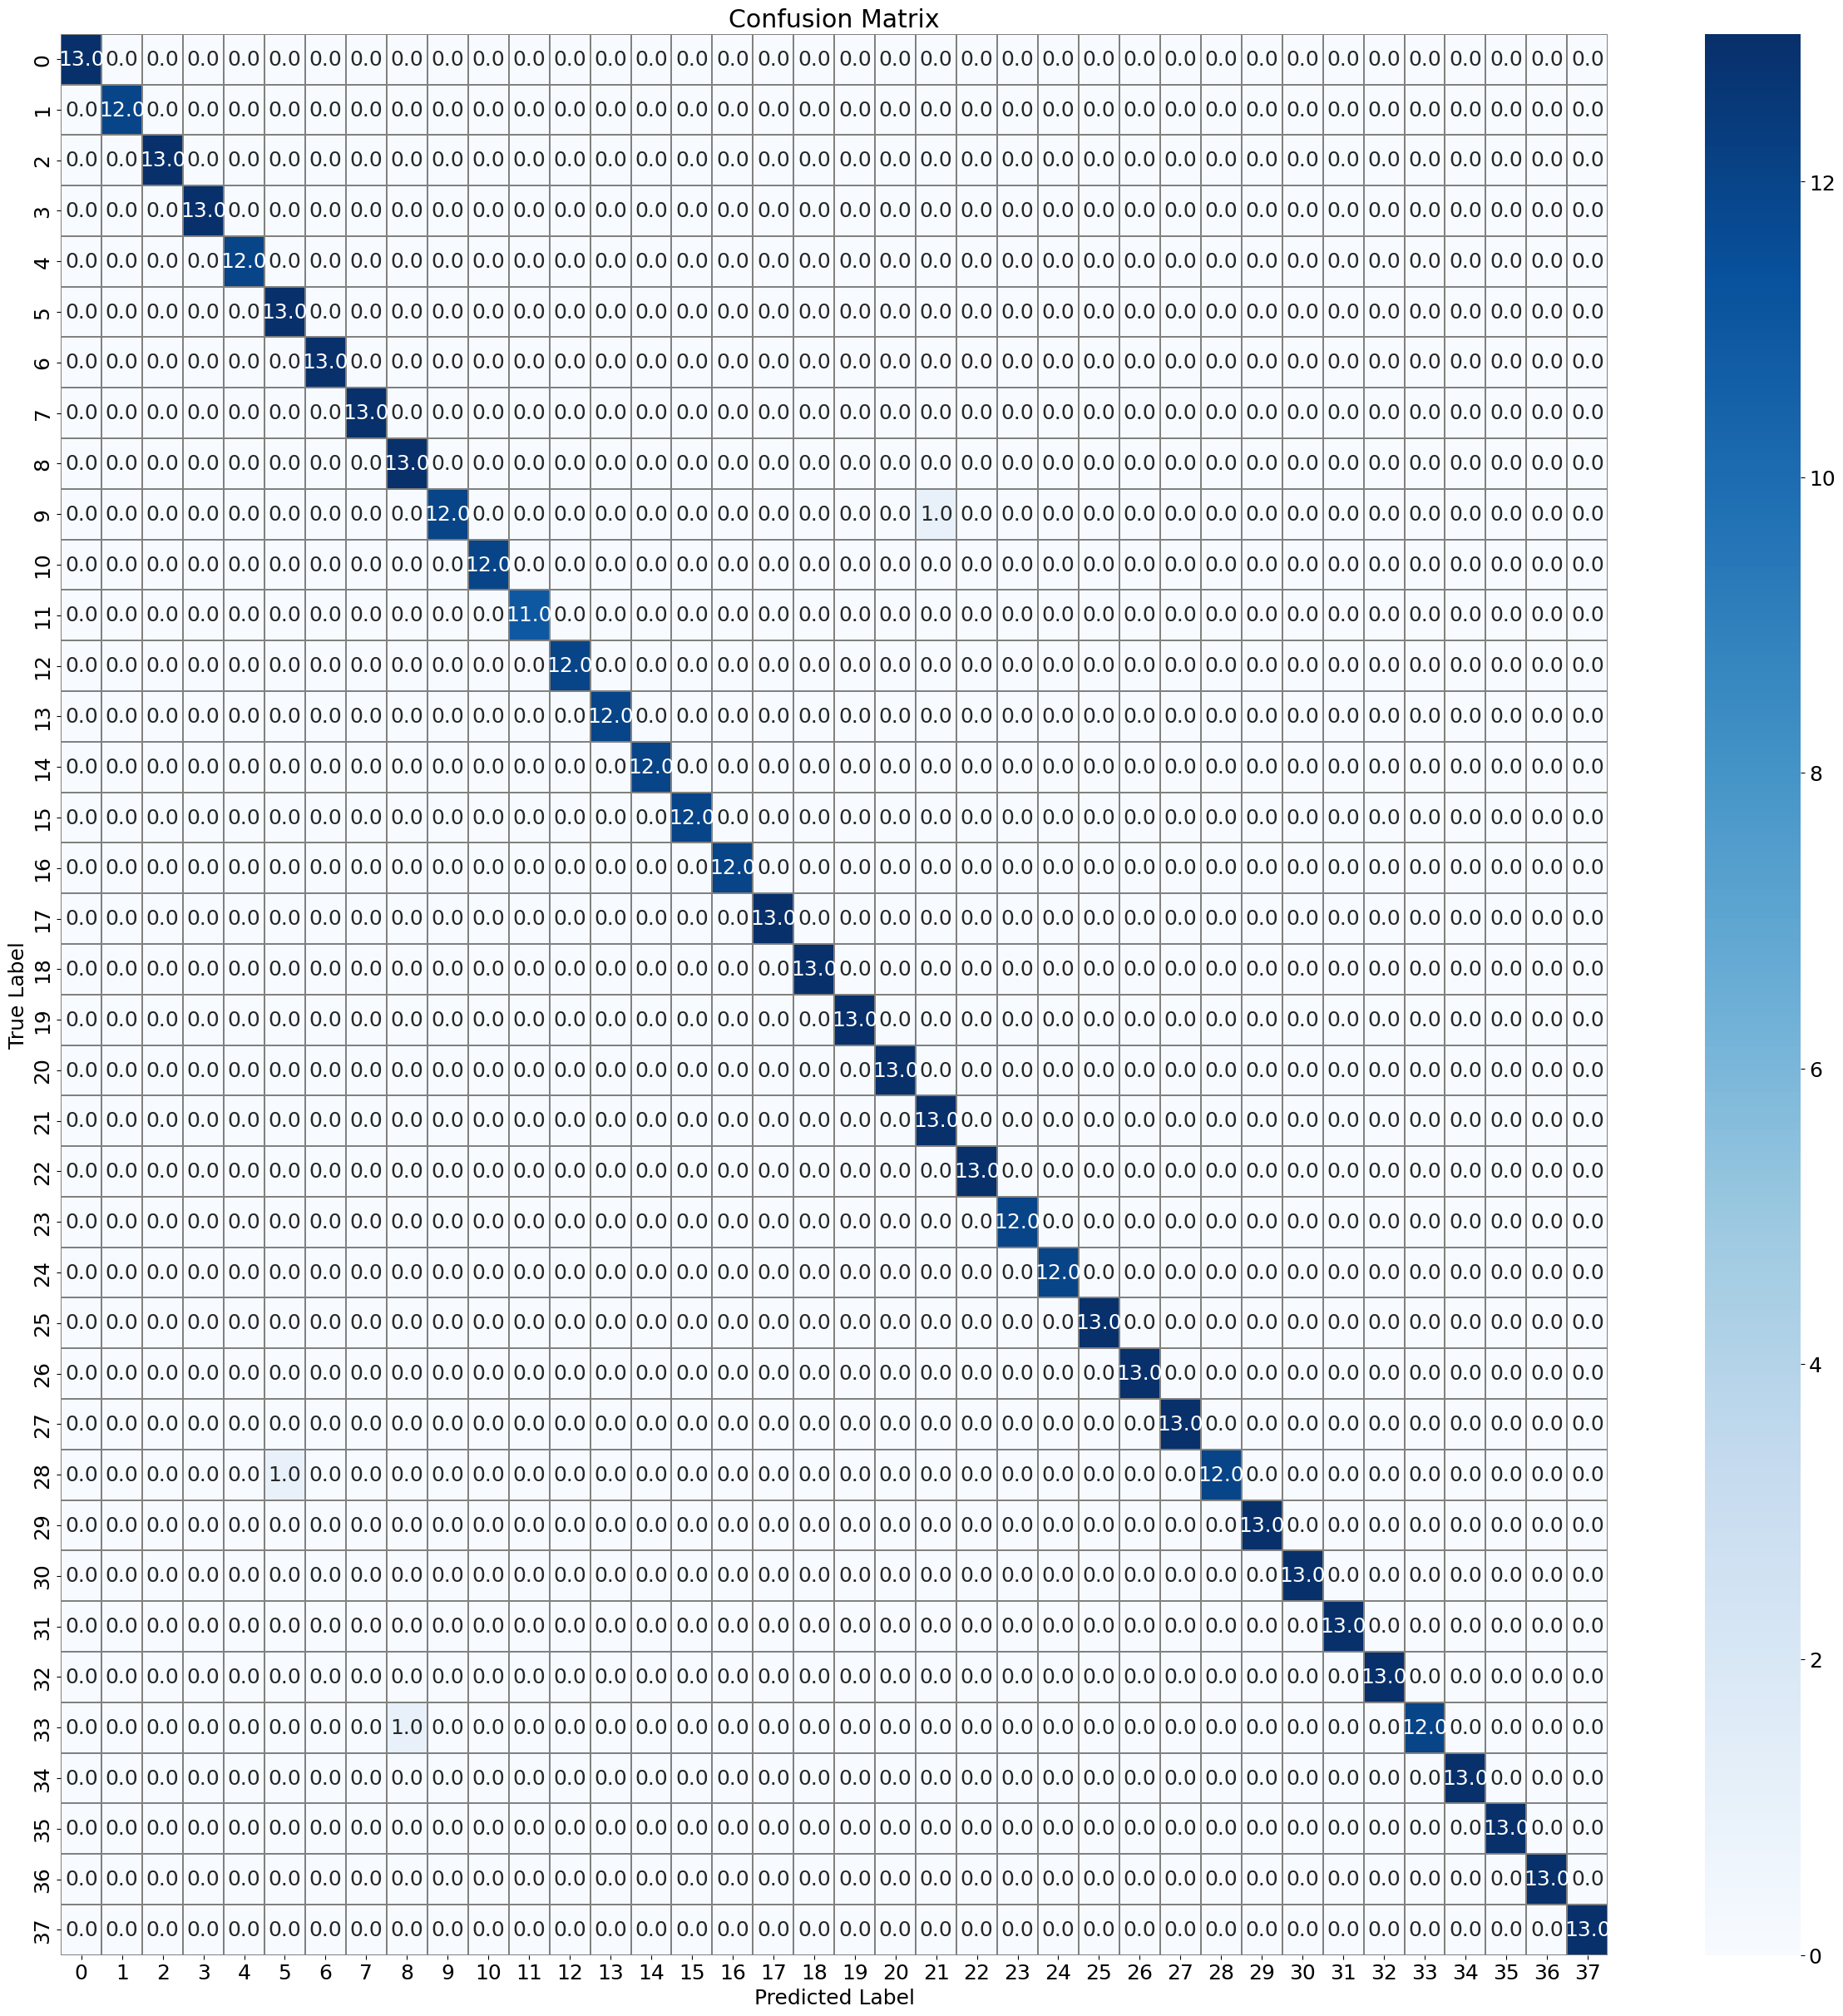

In [32]:
# confusion matrix
import seaborn as sns
# Predict the values from the validation dataset
Y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(30, 30))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Blues",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [11]:
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam

# Define the model function
def create_model(optimizer=Adam(), epochs=10, batch_size=32):
    model = Sequential()
    #
    model.add(Conv2D(filters = 8, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (n,m,1)))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    #
    model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.25))
    # fully connected
    model.add(Flatten())
    model.add(Dense(256, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(38, activation = "softmax"))
    #compile
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Create the model
model = KerasClassifier(build_fn=create_model)

# Define the grid of parameters
optimizers = [Adam(lr=0.001, beta_1=0.9, beta_2=0.999), Adam(lr=0.01, beta_1=0.9, beta_2=0.999)]
epochs = [10, 20, 25]
batches = [300, 400, 500]
param_grid = dict(optimizer=optimizers, epochs=epochs, batch_size=batches)

# Create the grid search object
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)

# Fit the grid search
grid_result = grid.fit(X_train, y_train)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


C:\Users\BBY2021\AppData\Local\Temp\ipykernel_22080\2242898509.py:30: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model)
d:\BBY2021\envs\tensorgpu\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/10
5/5 [==============================] - 5s 102ms/step - loss: 4.2768 - accuracy: 0.0218
Epoch 2/10
5/5 [==============================] - 1s 106ms/step - loss: 3.6738 - accuracy: 0.0304
Epoch 3/10
5/5 [==============================] - 0s 96ms/step - loss: 3.6288 - accuracy: 0.0319
Epoch 4/10
5/5 [==============================] - 1s 100ms/step - loss: 3.6264 - accuracy: 0.0296
Epoch 5/10
5/5 [==============================] - 0s 96ms/step - loss: 3.6238 - accuracy: 0.0405
Epoch 6/10
5/5 [==============================] - 0s 95ms/step - loss: 3.6158 - accuracy: 0.0428
Epoch 7/10
5/5 [==============================] - 1s 102ms/step - loss: 3.6088 - accuracy: 0.0506
Epoch 8/10
5/5 [==============================] - 1s 98ms/step - loss: 3.5972 - accuracy: 0.0521
Epoch 9/10
5/5 [==============================] - 1s 97ms/step - loss: 3.5801 - accuracy: 0.0537
Epoch 10/10
3/3 [==============================] - 0s 24ms/step - loss: 3.5955 - accuracy: 0.0653
Epoch 1/10
5/5 [=========

In [25]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import numpy as np


def create_model(filters, kernel_size, pool_size, dropout_rate_1, dropout_rate_2, dropout_rate_3, input_shape=(n, m, 1)):
    model = Sequential()
    
    # Convolutional layers
    model.add(Conv2D(filters=filters, kernel_size=kernel_size, padding='Same', activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(dropout_rate_1))
    
    model.add(Conv2D(filters=filters, kernel_size=kernel_size, padding='Same', activation='relu'))
    model.add(MaxPooling2D(pool_size=pool_size, strides=(2,2)))
    model.add(Dropout(dropout_rate_2))
    
    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(dropout_rate_3))
    
    # Output layer
    model.add(Dense(38, activation='softmax'))
    
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size) 
    return model


# Create the model wrapper for scikit-learn
model = KerasClassifier(build_fn=create_model, verbose=0)

# Define the hyperparameter grid
param_grid = {
    'filters': [8],  # Number of filters in the convolutional layers
    'kernel_size': [(3, 3), (5, 5)],
    'pool_size': [(2, 2), (3, 3)],  
    'dropout_rate_1': [0.25],  # Dropout rate after the first set of convolutional layers
    'dropout_rate_2': [0.5],  # Dropout rate after the second set of convolutional layers
    'dropout_rate_3': [0.5],  # Dropout rate after the dense layer
}

# Perform the grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters found: ", grid_result.best_params_)
print("Best accuracy found: {:.2f}%".format(grid_result.best_score_ * 100))

# Evaluate the best model on the test set
y_pred = grid.predict(X_test)

# Convert one-hot encoded predictions to integer format
y_pred_int = np.argmax(y_pred, axis=1)

# Compute accuracy with micro-average
accuracy = accuracy_score(y_test, y_pred_int, average='micro')
print("Accuracy on the test set: {:.2f}%".format(accuracy * 100))

C:\Users\BBY2021\AppData\Local\Temp\ipykernel_21540\83911974.py:36: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, verbose=0)


Epoch 1/30
7/7 [==============================] - 2s 109ms/step - loss: 3.8035 - accuracy: 0.0301
Epoch 2/30
7/7 [==============================] - 1s 99ms/step - loss: 3.6221 - accuracy: 0.0436
Epoch 3/30
7/7 [==============================] - 1s 98ms/step - loss: 3.6039 - accuracy: 0.0436
Epoch 4/30
7/7 [==============================] - 1s 100ms/step - loss: 3.5784 - accuracy: 0.0607
Epoch 5/30
7/7 [==============================] - 1s 100ms/step - loss: 3.5202 - accuracy: 0.0695
Epoch 6/30
7/7 [==============================] - 1s 98ms/step - loss: 3.4543 - accuracy: 0.0939
Epoch 7/30
7/7 [==============================] - 1s 99ms/step - loss: 3.3328 - accuracy: 0.1286
Epoch 8/30
7/7 [==============================] - 1s 101ms/step - loss: 3.1539 - accuracy: 0.1675
Epoch 9/30
7/7 [==============================] - 1s 103ms/step - loss: 2.9540 - accuracy: 0.2204
Epoch 10/30
7/7 [==============================] - 1s 101ms/step - loss: 2.6975 - accuracy: 0.2946
Epoch 11/30
7/7 [======

ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets

In [33]:
# Load the trained model
model = load_model('my_model.h5')

# Preprocess the image
image = preprocess_image(input_image)

# Make a prediction
predictions = model.predict(image[np.newaxis, ...])

# Extract probability vector
probability_vector = predictions[0]

# Interpret probabilities
predicted_class = np.argmax(probability_vector)
confidence = np.max(probability_vector)

print("Predicted class:", predicted_class)
print("Confidence:", confidence)


NameError: name 'load_model' is not defined

In [34]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

# Cargar el modelo pre-entrenado (por ejemplo, ResNet50)
model = tf.keras.applications.ResNet50(weights='imagenet')

# Cargar una imagen y preprocesarla
img_path = 'dog.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = preprocess_input(x)
x = tf.expand_dims(x, axis=0)

# Obtener el vector de probabilidades de salida
predictions = model.predict(x)

# Decodificar las predicciones (esto dependerá del modelo que estés usando)
decoded_predictions = decode_predictions(predictions, top=3)[0]

# Imprimir las predicciones más probables
for i, (imagenet_id, label, prob) in enumerate(decoded_predictions):
    print(f"{i + 1}: {label} ({prob:.2f})")


102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 40s 0us/step


FileNotFoundError: [Errno 2] No such file or directory: 'dog.jpg'